In [118]:
import numpy as np # linear algebra
import pandas as pd
import os
import json
import re, string
import sys
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize

In [119]:
def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [121]:
yelp_review = read_json("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
# yelp_review["date"] = pd.to_datetime(yelp_review["date"], format = "%Y-%m-%d")

In [122]:
def tokenize(s):
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list]
    return filtered_words

## Mean shift clustering

In [193]:
doc = yelp_review.text[0:100]
review_length = []
for line in doc:
    words = tokenize(line)
#     print(words)
    review_length.append(len(words))
print(len(review_length))

100


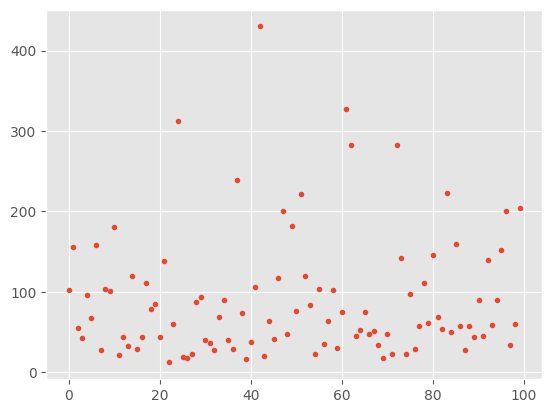

In [194]:
x = np.arange(len(review_length))
y = review_length
# plt.scatter(x, y)
plt.plot(x,y, ".")

In [195]:
points = np.column_stack((x,y))

In [196]:
def euclid_dist(p1,p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)   

def gaussianKernel(distance, bandwidth):
    return (1/(bandwidth*np.sqrt(2*np.pi))) * np.exp(-0.5*((distance/bandwidth))**2)

def shiftModeGaussian(x, data, h):
    num = 0.0
    den = 0.0
    for xi in data:
        dist = np.linalg.norm(x - xi)
        weight = gaussianKernel(dist, h)
        num += weight * xi
        den += weight
    return num / den

def shiftMode(mode, points, bandwidth):
    shift = np.zeros(len(mode))
    weight = np.zeros(len(mode))
    for i in range(len(points)):
        distance = euclid_dist(mode, points[i])
        if distance < bandwidth:
            kernel = 1
            shift += kernel * points[i]
            weight += kernel
    if np.sum(weight) > 0:
        shift /= np.sum(weight)
    return shift


def meanShiftClustering(data, h, tau):
    modes = []
    for xi in data:
        mode = [xi]
        m = 0
        while True:
            mode.append(shiftMode(mode[m], data, h))
            m += 1
            if euclid_dist(mode[m],mode[m-1]) < tau:
                break
        modes.append(mode[m])
    # Merge modes that are too close
    merged_modes = []
    for i in range(len(modes)):
        if modes[i] is None:
            continue
        for j in range(i+1, len(modes)):
            if modes[j] is None:
                continue
            if euclid_dist(modes[i],modes[j]) < tau:
                modes[j] = None
        merged_modes.append(modes[i])
    return np.array(merged_modes)


In [197]:
h = 50
tau = 1e-1
modes = meanShiftClustering(points, h, tau)
print(modes)

[[14.25925926 16.55555556]]


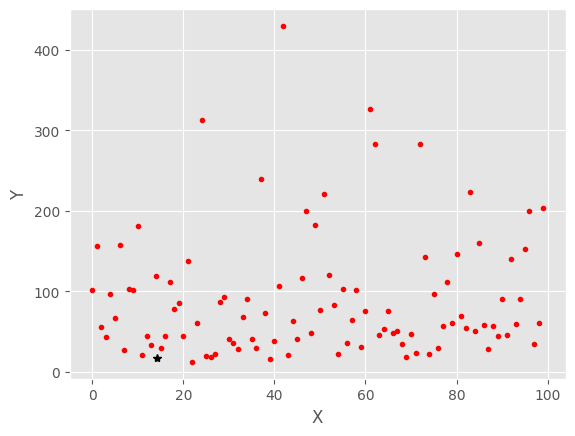

In [198]:
# Visualize the modes
plt.plot(points[:, 0], points[:, 1], 'r.')
plt.plot(modes[:, 0], modes[:, 1], 'k*')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [199]:
class Mean_Shift:
    def __init__(self, radius=200):
        self.radius = radius

    def fit(self, data):
        centroids = {}

        for i in range(len(data)):
            centroids[i] = data[i]
        
        while True:
            new_centroids = []
            for i in centroids:
                in_bandwidth = []
                centroid = centroids[i]
                for featureset in data:
                    if np.linalg.norm(featureset-centroid) < self.radius:
                        in_bandwidth.append(featureset)

                new_centroid = np.average(in_bandwidth,axis=0)
                new_centroids.append(tuple(new_centroid))

            uniques = sorted(list(set(new_centroids)))

            prev_centroids = dict(centroids)

            centroids = {}
            for i in range(len(uniques)):
                centroids[i] = np.array(uniques[i])

            optimized = True

            for i in centroids:
                if not np.array_equal(centroids[i], prev_centroids[i]):
                    optimized = False
                if not optimized:
                    break
                
            if optimized:
                break

        self.centroids = centroids

In [200]:
X = points
clf = Mean_Shift()
clf.fit(X)

centroids = clf.centroids
print(len(centroids))

3


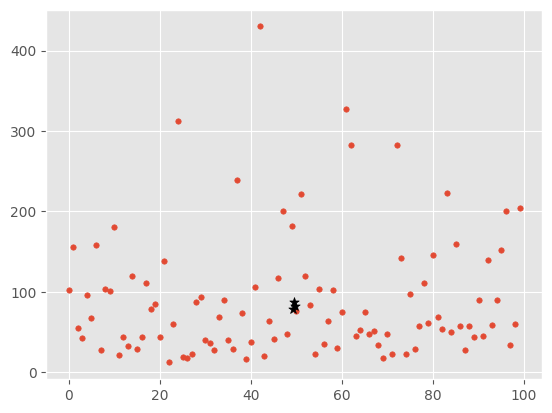

In [201]:
X = points

fig,ax=plt.subplots(1,1)
ax.scatter(X[:,0], X[:,1], s=15)
for c in centroids:
    ax.scatter(centroids[c][0], centroids[c][1], color='k', marker='*', s=50)    
plt.show()